# Theory

In [44]:
import numpy as np

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("darkgrid")

## Generating a sample

The probability density function of the univariate Gaussian is given by:

$$f(x | \mu, \sigma^{2}) = \frac{1}{\sqrt{2\pi \sigma^{2}}}e^{-\frac{1}{2\sigma^{2}}(x - \mu)^{2}}$$

[-4.   -3.99 -3.98 ...  9.97  9.98  9.99]
Shape: (500,)


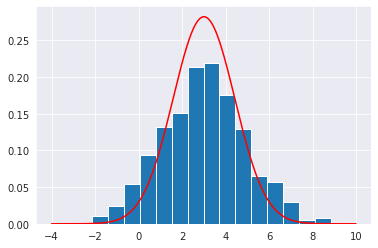

In [45]:
# set the random seed
rng = np.random.default_rng(42)
# generate a sample of normally distributed random variables with mean mu and variance var
mu = 3
var = 2
# generate a random sample using the numpy function
sample = rng.normal(mu, var, 500)

def pdf(x, mu, var):
    """
        Return a vector (shape of x) of the probabilities
        of the values of x
    """
    return 1 / (np.sqrt(2*np.pi*var)) * np.exp(-1/(2*var)*(x - mu)**2)

xx = np.arange(-4, 10, 0.01)

print(xx)
probs = pdf(xx, mu, var)

print(f"Shape: {sample.shape}")

plt.hist(sample, bins=15, density=True);
plt.plot(xx, probs, c='red')

## Maximum Likelihood Estimation

Here we minimise the likelihood function for the univariate Gaussian pdf. This allows us to find the best-fitting parameters.

The log-likelihood of the univariate Gaussian is given by:

$$\log \mathcal{L}(\mu, \sigma^{2}| \vec{x}) = -\frac{n}{2} \log (2\pi) - \frac{n}{2} \log \sigma^{2} - \frac{1}{2\sigma^{2}}\sum_{i = 1}^{n} (x_{i} - \mu)^{2}$$

and hence we want to minimise

$$\hat{\mu} = -\text{argmin}_{\mu} \log \mathcal{L}(\mu, \sigma^{2} | \vec{x})$$

In [46]:
# define the univariate Gaussian likelihood
def likelihood(params, x):
    mu = params
    sigma = 2
    n = len(x)
    L = (n/2)*np.log(2*np.pi)+(n/2)*np.log(sigma**2)+(1/(2*sigma**2))*sum((x-mu)**2)
    return L

## Evaluating the likelihood function

Evaluating the likelihood function over a range of values, we can geometrically approximate the MLE to be zero.

Text(0.5, 0, 'Mean value: $\\mu$')

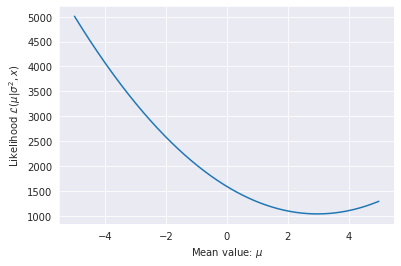

In [47]:
mu = np.arange(-5, 5, 0.01)
likelihood_values = []

for val in mu:
    likelihood_values.append(likelihood(val, sample))
     
plt.plot(mu, likelihood_values)
plt.ylabel("Likelihood $\mathcal{L}(\mu | \sigma^{2}, x)$")
plt.xlabel("Mean value: $\mu$")

## Minimising the likelihood function using scipy.optimize.minimize

In [48]:
initial_guess = rng.random()

lik_sim = Simulator(likelihood)

lik_model = minimize(lik_sim.simulate, x0=initial_guess,
                     args=(sample),
                     method="Nelder-Mead",
                     tol=1e-6,
                     options={"disp": True})

lik_model.x

Optimization terminated successfully.
         Current function value: 1035.950498
         Iterations: 28
         Function evaluations: 56


array([2.97374775])

In [63]:
test = np.array((lik_sim.list_calls_inp, np.array(lik_sim.list_calls_res)))

test

/tmp/ipykernel_13930/2974102180.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test = np.array((lik_sim.list_calls_inp, np.array(lik_sim.list_calls_res)))


array([[array([0.37226157]), array([0.39087465]), array([0.40948773]),
        array([0.42810081]), array([0.46532697]), array([0.50255312]),
        array([0.57700544]), array([0.65145775]), array([0.80036238]),
        array([0.94926701]), array([1.24707627]), array([1.54488553]),
        array([2.14050405]), array([2.73612256]), array([3.9273596]),
        array([3.33174108]), array([2.14050405]), array([3.03393182]),
        array([3.33174108]), array([2.88502719]), array([3.18283645]),
        array([2.95947951]), array([2.88502719]), array([2.99670566]),
        array([2.92225335]), array([2.97809259]), array([2.99670566]),
        array([2.96878605]), array([2.98739912]), array([2.97343932]),
        array([2.96878605]), array([2.97576595]), array([2.97111268]),
        array([2.97460263]), array([2.972276]), array([2.97402097]),
        array([2.97460263]), array([2.97373015]), array([2.97343932]),
        array([2.97387556]), array([2.97358473]), array([2.97380285]),
        a

## Setting $\mu$ to be a function of some parameters $a$, $b$

Let $\mu(a, b) = ax^{2} + bx^{2}$

In [25]:
def model(params, x):
    a, b = params
    return a*x**2 + np.exp(x)

In [26]:
# define the univariate Gaussian likelihood
def likelihood(params, x):
    mu = model(params, x)
    sigma = 2
    n = len(x)
    L = (n/2)*np.log(2*np.pi)+(n/2)*np.log(sigma**2)+(1/(2*sigma**2))*sum((x-mu)**2)
    return L

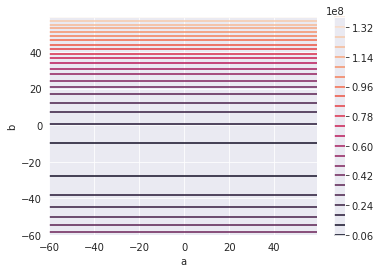

In [27]:
a = np.arange(-60, 60, 1)
b = np.arange(-60, 60, 1)

aa, bb = np.meshgrid(a, b, indexing='ij')

values = np.array((aa, bb)).T.reshape(-1, 2)

likelihood_values = np.zeros(values.shape[0])

for idx, val in enumerate(values):
    likelihood_values[idx] = likelihood(val, sample)
    
likelihood_values

plt.contour(aa, bb, likelihood_values.reshape(aa.shape), 20)
plt.ylabel("b")
plt.xlabel("a")
plt.colorbar()

In [92]:
class Simulator:
    def __init__(self, objective):
        self.objective = objective # define objective function
        self.call_count = 0 # how many times the objective function has been called
        self.callback_count = 0 # number of times callback has been called, also measures iteration count
        self.list_calls_inp = [] # parameter inputs for all calls
        self.list_calls_res = [] # loss value output for all calls
        self.decreasing_list_calls_inp = [] # parameter inputs that resulted in decrease
        self.decreasing_list_calls_res = [] # loss value outputs that resulted in decrease
        self.list_callback_inp = [] # only appends inputs on callback, as such they correspond to the iterations
        self.list_callback_res = [] # only appends results on callback, as such they correspond to the iterations

    def simulate(self, x, *args):
        """
            Executes the simulation.
            Returns the result and updates the lists for the callback.
            Pass to the optimiser as the objective function.
        """
        result = self.objective(x, *args) # evaluate the objective function
        if not self.call_count: # first call is stored in all lists
            self.decreasing_list_calls_inp.append(x[0])
            self.decreasing_list_calls_res.append(result)
            self.list_callback_inp.append(x)
            self.list_callback_res.append(result)
        elif result < self.decreasing_list_calls_res[-1]:
            self.decreasing_list_calls_inp.append(x)
            self.decreasing_list_calls_res.append(result)
        self.list_calls_inp.append(x[0])
        self.list_calls_res.append(result)
        self.call_count += 1
        return result
    
    def callback(self, xk, *_):
        s1 = ""
        xk = np.atleast_1d(xk)
        for i, x in reversed(list(enumerate(self.list_calls_inp))):
            x = np.atleast_1d(x)
            if np.allclose(x, xk):
                break

        for comp in xk:
            s1 += f"{comp:10.5e}\t"
        s1 += f"{self.list_calls_res[i]:10.5e}"

        self.list_callback_inp.append(xk)
        self.list_callback_res.append(self.list_calls_res[i])

        if not self.callback_count:
            s0 = ""
            for j, _ in enumerate(xk):
                tmp = f"Comp-{j+1}"
                s0 += f"{tmp:10s}\t"
            s0 += "Objective"
            print(s0)
        print(s1)
        self.callback_count += 1

        
likelihood_sim = Simulator(likelihood)
minimize(likelihood_sim.simulate,
         x0=initial_guess,
         args=sample,
         method="Nelder-Mead",
         options={"disp": True})

Optimization terminated successfully.
         Current function value: 1035.950498
         Iterations: 21
         Function evaluations: 42


 final_simplex: (array([[2.97373015],
       [2.97380285]]), array([1035.95049849, 1035.95049866]))
           fun: 1035.9504984860844
       message: 'Optimization terminated successfully.'
          nfev: 42
           nit: 21
        status: 0
       success: True
             x: array([2.97373015])

In [94]:
likelihood_sim.list_calls_inp

[0.3722615731915482,
 0.3908746518511256,
 0.409487730510703,
 0.42810080917028026,
 0.46532696648943495,
 0.5025531238085896,
 0.577005438446899,
 0.6514577530852084,
 0.8003623823618271,
 0.9492670116384458,
 1.2470762701916833,
 1.544885528744921,
 2.1405040458513964,
 2.736122562957872,
 3.9273595971708226,
 3.331741080064347,
 2.1405040458513964,
 3.0339318215111097,
 3.3317410800643477,
 2.8850271922344906,
 3.182836450787729,
 2.9594795068728,
 2.8850271922344906,
 2.996705664191955,
 2.922253349553645,
 2.9780925855323774,
 2.9967056641919547,
 2.968786046202589,
 2.987399124862166,
 2.9734393158674832,
 2.968786046202589,
 2.9757659506999303,
 2.971112681035036,
 2.9746026332837068,
 2.9722759984512597,
 2.9740209745755948,
 2.9746026332837063,
 2.973730145221539,
 2.9734393158674832,
 2.973875559898567,
 2.973584730544511,
 2.973802852560053]

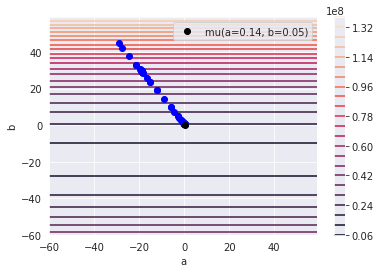

In [40]:
plt.contour(aa, bb, likelihood_values.reshape(aa.shape), 20)
plt.ylabel("b")
plt.xlabel("a")
plt.plot(test[0], test[1], 'bo')
plt.plot(lik_model.x[0], lik_model.x[1], 'ko', label=f"mu(a={lik_model.x[0]:.2f}, b={lik_model.x[1]:.2f})")
plt.legend()
plt.colorbar()

In [16]:
initial_guess = rng.random(2)

print(initial_guess)

def callback_function(Xi):
    global nfev
    print(f"{nfev}, {Xi[0]}, {Xi[1]}")
    Nfeval += 1

lik_model = minimize(likelihood, x0=initial_guess,
                     args=(sample),
                     method="Nelder-Mead",
                     tol=1e-6,
                     callback=callback_function,
                     options={"disp": True})

lik_model.x

[0.11967256 0.36491936]
Optimization terminated successfully.
         Current function value: 893.249084
         Iterations: 56
         Function evaluations: 113


array([0.13940925, 0.04673377])

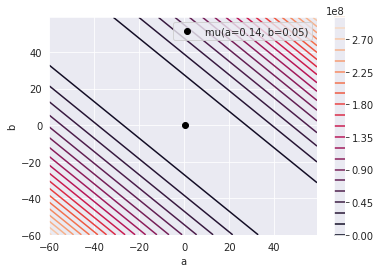

In [17]:
plt.contour(aa, bb, likelihood_values.reshape(aa.shape), 20)
plt.ylabel("b")
plt.xlabel("a")
plt.plot(lik_model.x[0], lik_model.x[1], 'ko', label=f"mu(a={lik_model.x[0]:.2f}, b={lik_model.x[1]:.2f})")
plt.legend()
plt.colorbar()

In [90]:
test = np.array([])

print(test)

test = np.append(test, 3)

print(test)

[]
[3.]
